In [1]:
import pandas as pd
import random
import itertools

min_bet = 2
max_bet = 500
init_amount = 1000

def cardDeck(number_of_decks=1):
    '''
    Generates N new decks. The deck is shuffled
    '''
    # Suit = 12 cards
    suit = [1,2,3,4,5,6,7,8,9,10,10,10,10] * number_of_decks
    
    # 4 suits comprise a deck
    deck = suit * 4
    
    # Shuffle deck: then each card is picked from the top of the deck
    random.shuffle(deck)
    
    # Discard the first card - the burn
    # deck = deck[1:]
    
    return deck

In [2]:
def startingCards(card_deck, players_number=4):
    '''
    Deals starting cards (2 per player and dealer). Returns each player's cards and the remaining deck
    '''
    
    card_deck = card_deck.copy()
    hand = {}
    
    # Constants
    dealer = 1
    cards_dealt_per_player=2
    
    # Deal hands
    while cards_dealt_per_player > 0:
        
        for p in range(1, players_number + dealer + 1):

            card_value = card_deck[0]
            player_id = 'P'+str(p)
            
            if p > players_number:
                
                if 'Dealer' not in hand:
                    hand['Dealer'] = [card_value]
                                         
                else:
                    hand['Dealer'].append(card_value)
                                         
            else:
                if player_id not in hand:
                    hand[player_id] = [card_value]
                                         
                else:
                    hand[player_id].append(card_value)
            
            card_deck.remove(card_value)
        
        cards_dealt_per_player -= 1
    
    return hand, card_deck

In [20]:
def dealNew(hand_dict, remaining_card_deck, player_id):
    '''
    Deals a new card to each bettor who wants to be dealt
    
    Arguments:
    bettor_hands: a dictionary of lists | keys are player ids - values are lists of their hands
    remaining_card_deck: a list of the remaining cards
    '''
    
    remaining_card_deck = remaining_card_deck.copy()
    
#     try:
#         print(len(remaining_card_deck))
#     except:
#         ''

    card_value = remaining_card_deck[0]
        
    hand_dict[player_id].append(card_value)

#     print(remaining_card_deck)
    remaining_card_deck.remove(card_value)

    return hand_dict, remaining_card_deck

In [4]:
def calcHandValue(input_list):
    '''
    '''
    
    # Input list
    input_list = input_list.copy()

    # Drop aces
    cards_ex_aces = [i for i in input_list if i!=1]

    # Count aces
    num_aces = input_list.count(1)

    # Create 2 lists: aces and elevens
    aces = [1 for i in range(1, num_aces+1)]
    elevens = [11 for i in range(1, num_aces+1)]

    # Calculate all possible combinations
    combos = list(set([x for x in itertools.combinations(aces+elevens, num_aces)])) #_with_replacement
    combos = [list(c) + cards_ex_aces for c in combos]

    max_hand_val = 0
    for c in combos:
        if (sum(c)>max_hand_val) & (sum(c)<=21):
            max_hand_val = sum(c)

    # If the total sum is bust then replace 0 with a value above 21
    if max_hand_val == 0:
        max_hand_val = 100
        
    return max_hand_val

In [5]:
def stand(player_hand_val, hands_dict, remaining_card_deck):
    '''
    Once the player decides to stand, the dealer reveals their hand and draws new ones if required
    
    Arguments:
    player_hand_val: an int value of player's hand
    hands_dict: a dictionary with all parties hands
    remaininng_card_deck: a list with the remaining cards in the deck
    '''
    
    remaining_card_deck = remaining_card_deck.copy()
    
    loop = True
    who_wins = ""

    # The dealer draws cards at least until their hand's sum is equal to or higher than 17
    while loop:

        dealer_hand_val = calcHandValue(hands_dict['Dealer'])

        if dealer_hand_val <= 21:
            
            if dealer_hand_val > player_hand_val:
                who_wins = 'House wins'
                loop = False

            # The dealer won't draw since their cards' value is at least 17
            if dealer_hand_val >= 17:

                # So it's either a draw
                if dealer_hand_val == player_hand_val:
                    who_wins = 'No one wins'
                    loop = False

                # ..or a win for the player
                elif player_hand_val > dealer_hand_val:
                    who_wins = 'Player wins'
                    loop = False

            if loop:
#                 print('In here')
                hands_dict, remaining_card_deck = dealNew(hands_dict, remaining_card_deck, player_id='Dealer')
                
        else:
            who_wins = 'Player wins'
            loop = False

    return who_wins, hands_dict, remaining_card_deck

In [6]:
def play_game(player_hands, remaining_deck, pid='P1'):

    dealers_face_on = player_hands['Dealer'][0]
    
    loop = True
    
    while loop:
        
        # Estimate hand value
        p_val = calcHandValue(player_hands[pid])
        
        if p_val <=21:
            # If the player's hand is at least 17, then stand
            if p_val >= 17: 
                outcome, updated_hand, updated_deck = stand(player_hand_val = p_val,
                                                  hands_dict = player_hands,
                                                  remaining_card_deck = remaining_deck)
                loop = False

            # Else if the p's hand is at least 13, then it depends on the dealer's hand
            elif p_val >=13:

                # If the dealer's face on card is less than 7, then the player stands
                if dealers_face_on < 7:
                    outcome, updated_hand, updated_deck = stand(player_hand_val = p_val,
                                                      hands_dict = player_hands,
                                                      remaining_card_deck = remaining_deck)
                    loop = False


                # If the dealer's face on card is at least 7, the the player hits / asks new card
                elif dealers_face_on >= 7:
#                     print('In here 11')
                    player_hands, remaining_deck = dealNew(player_hands, remaining_deck, player_id=pid)


            # Else if the p's hand is exactly 12, then it depends on the dealer's hand
            elif p_val == 12:

                # If the dealer's face on card is either of 4, 5 or 6, then the player stands
                if dealers_face_on in [4,5,6]:
                    outcome, updated_hand, updated_deck = stand(player_hand_val = p_val,
                                                      hands_dict = player_hands,
                                                      remaining_card_deck = remaining_deck)
                    loop = False

                # All other cases, the player hits
                else:
#                     print('In here 12')
                    player_hands, remaining_deck = dealNew(player_hands, remaining_deck, player_id=pid)

            elif p_val < 12:
#                 print('In here 13')
                player_hands, remaining_deck = dealNew(player_hands, remaining_deck, player_id=pid)
                
        else:
            outcome = 'House wins'
            updated_hand = player_hands
            updated_deck = remaining_deck
            loop = False

            
    return outcome, updated_hand, updated_deck

In [49]:
def playDeck(remaining_deck):
    
    results = pd.DataFrame(columns = ['Result','Dealer','Player','Cards Remaining'])
    # print(len(remaining_deck))
    g = 1
    while len(remaining_deck) > 8:
        
        try:
            player_hands, remaining_deck = startingCards(card_deck = remaining_deck, players_number=1)

            
            outcome, player_hands, remaining_deck = play_game(player_hands, remaining_deck)

            results.loc['Game '+str(g),'Result'] = outcome
            results.loc['Game '+str(g),'Dealer'] = player_hands['Dealer']
            results.loc['Game '+str(g),'Player'] = player_hands['P1']
            results.loc['Game '+str(g),'Cards Remaining'] = len(remaining_deck)
            
#             print('Game ' + str(g))
#             print('Hands')
#             print(player_hands)
#             print('Rem deck length ' + str(len(remaining_deck)))
#             print(' ')
            
        except Exception as e:
            print(e)
            break
        
        g+=1
        
    return results

In [50]:
# New deck
starting_deck = cardDeck()

# Play deck
result = playDeck(remaining_deck=starting_deck)

In [74]:
sim_results = pd.DataFrame(columns = ['Games played','Dealer Wins','Player Wins','Push'])

for s in range(1,3001):
    
    starting_deck = cardDeck()
    result = playDeck(remaining_deck=starting_deck)
    
    sim_results.loc['Simulation '+str(s), 'Games played'] = len(result)
    
    try:
        sim_results.loc['Simulation '+str(s), 'Dealer Wins'] = result['Result'].value_counts().loc['House wins']
    except:
        ''
    
    try:
        sim_results.loc['Simulation '+str(s), 'Player Wins'] = result['Result'].value_counts().loc['Player wins']
    except:
        ''
    
    try:
        sim_results.loc['Simulation '+str(s), 'Push'] = result['Result'].value_counts().loc['No one wins']
    except:
        ''

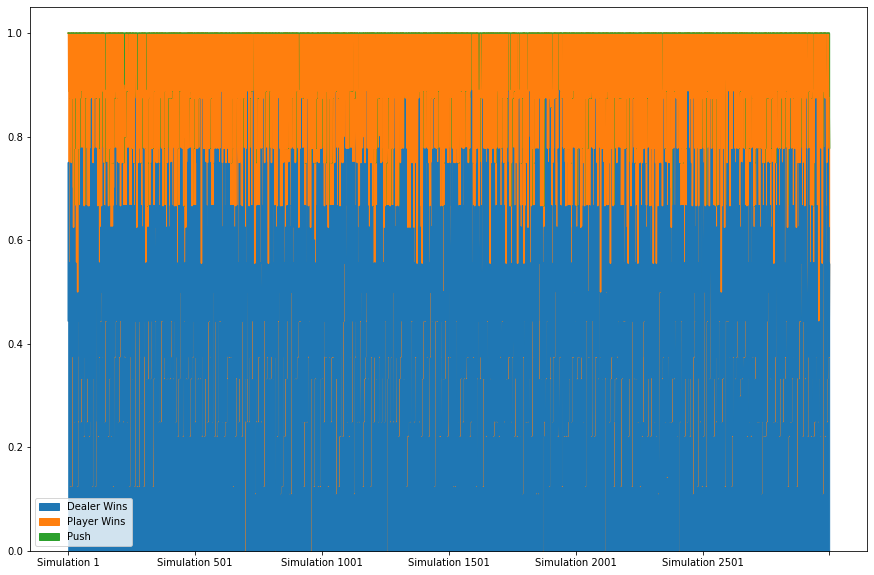

In [80]:
sim_results[['Dealer Wins', 'Player Wins', 'Push']].divide(sim_results["Games played"],
                                                           axis=0).plot(kind='area', figsize=(15,10))

In [78]:
sim_results[['Dealer Wins', 'Player Wins', 'Push']].divide(sim_results["Games played"],
                                                           axis=0).mean()

Dealer Wins    0.523540
Player Wins    0.392977
Push           0.161026
dtype: float64

In [79]:
sim_results[['Dealer Wins', 'Player Wins', 'Push']].divide(sim_results["Games played"],
                                                           axis=0).median()

Dealer Wins    0.555556
Player Wins    0.375000
Push           0.125000
dtype: float64